In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('LoanStats3a.csv',low_memory=False)

In [3]:
df.shape

(42538, 144)

In [4]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

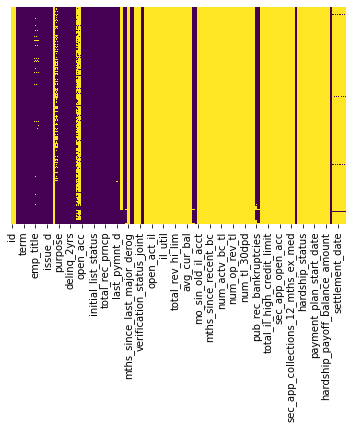

In [5]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [6]:
#Response/Target Variable 
df.loan_status.value_counts()

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

In [7]:
#Considering only Fully Paid, Default, Charged Off Loans.
df["loan_status"] = np.where(df["loan_status"].str.contains("Fully"), 0, 1)

In [8]:
# Changing employee length to numerical.
df['emp_length'].fillna("< 1 year",inplace= True)
dict_emp_length = {'10+ years':10, '6 years':6, '4 years':4, '< 1 year':0.5, '2 years':2,'9 years':9, '5 years':5, '3 years':3, '7 years':7, '1 year':1,'8 years':8}
df['emp_length'].replace(dict_emp_length, inplace=True)

In [9]:
#set fraction
frac = 42538*0.80 #80% of max columns.
frac

34030.4

In [10]:
df.columns[df.isnull().sum()>=frac]

Index(['id', 'member_id', 'url', 'mths_since_last_record', 'next_pymnt_d',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_

In [ ]:
#df.drop(df.columns[df.isnull().sum()>=34030],axis = 1,inplace=True)

In [11]:
leak_cols = ['id', 'member_id', 'url', 'mths_since_last_record', 'next_pymnt_d',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
       'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
       'hardship_loan_status', 'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term']
#drop leaks
df_small = df.drop(columns=leak_cols, axis=1)
drop_col_count = len(leak_cols)
print("The new dataframe has {} columns and lost {} after dropping future leaks".format(df_small.shape[1],
                                                                           drop_col_count))

The new dataframe has 54 columns and lost 90 after dropping future leaks


In [12]:
df_small.shape

(42538, 54)

In [13]:
#remove columns that have only 1 feature
#get unique values per feature
nunique_value = df_small.apply(pd.Series.nunique)
#note columns that have single value
single_value_cols = nunique_value[nunique_value == 1].index.tolist()
print(single_value_cols)

['pymnt_plan', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'chargeoff_within_12_mths', 'hardship_flag']


In [14]:
# drop the redundant columns
df_small = df_small.drop(columns=single_value_cols)

In [15]:
#make dataframe to record mean missing
nan_df = pd.DataFrame(df_small.isna().mean(), columns=['mean_nan'])
#add dtypes
nan_df['dtypes'] = df_small.dtypes
#sort by most missing at top
nan_df = nan_df.sort_values(by=['mean_nan'], ascending=False)

nan_df = nan_df.reset_index()

nan_df.head()

,index,mean_nan,dtypes
0,mths_since_last_delinq,0.633058,float64
1,desc,0.312568,object
2,emp_title,0.061804,object
3,pub_rec_bankruptcies,0.032159,float64
4,tax_liens,0.002539,float64


In [16]:
a=df_small.isnull().sum()/len(df_small)*100
variables = df_small.columns
variable = [ ]
for i in range(0,len(df_small.columns)):
    if a[i]<50:   # setting the threshold as 90% (MissingValue)
        variable.append(variables[i])
# Dropping Columns based on missing data being more than 60% 
drop_columns1=list(set(variables) - set(variable))
df_drop_nan=df_small.drop(columns=drop_columns1)

In [17]:
df_drop_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                42535 non-null  float64
 1   funded_amnt              42535 non-null  float64
 2   funded_amnt_inv          42535 non-null  float64
 3   term                     42535 non-null  object 
 4   int_rate                 42535 non-null  object 
 5   installment              42535 non-null  float64
 6   grade                    42535 non-null  object 
 7   sub_grade                42535 non-null  object 
 8   emp_title                39909 non-null  object 
 9   emp_length               42538 non-null  float64
 10  home_ownership           42535 non-null  object 
 11  annual_inc               42531 non-null  float64
 12  verification_status      42535 non-null  object 
 13  issue_d                  42535 non-null  object 
 14  loan_status           

In [18]:
def df_object_to_num(df_obj):
    
    """Custom function to transform categorical features into numerical ones
    This function will also be applied on the testing data so that we apply the same exact kind of transformation
    """
    
    #make deep copy
    df_num = df_obj.copy()
    
    col_drop_list = ['emp_title']
    
    #pub_rec_bankruptcies
    df_num['pub_rec_bankruptcies'] = np.where(df_num['pub_rec_bankruptcies']>0, 1, 0)
    # pub_rec
    df_num['pub_rec'] = np.where(df_num['pub_rec']>0, 1, 0)
    
     ### instantiate dicts ### 
    term_to_int = {' 36 months': 1,
                   ' 60 months': 2}
    grade_to_int = dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G'], np.arange(7, 0, -1)))
    
    #copied from above, we can write a function to generate this dict
    sub_grade_sorted = {'G5': 0, 'G4': 1, 'G3': 2, 'G2': 3, 'G1': 4,
                        'F5': 5, 'F4': 6, 'F3': 7, 'F2': 8, 'F1': 9,
                        'E5': 10, 'E4': 11, 'E3': 12, 'E2': 13, 'E1': 14,
                        'D5': 15, 'D4': 16, 'D3': 17, 'D2': 18, 'D1': 19,
                        'C5': 20, 'C4': 21, 'C3': 22, 'C2': 23, 'C1': 24,
                        'B5': 25, 'B4': 26, 'B3': 27, 'B2': 28, 'B1': 29,
                        'A5': 30, 'A4': 31, 'A3': 32, 'A2': 33, 'A1': 34}    
    home_to_int = {'MORTGAGE': 4, 'RENT': 3, 'OWN': 5,'ANY': 2,'OTHER': 1, 'NONE':0 }
    ver_stat_to_int = {'Source Verified':2,'Verified': 1,'Not Verified': 0}
    
    #replacements
    df_num.replace({'term': term_to_int, 
                    'grade':grade_to_int,
                    'sub_grade': sub_grade_sorted,
                    'home_ownership':home_to_int,
                    'verification_status':ver_stat_to_int}, inplace=True)
    col_drop_list.append('zip_code')
    
    df_num['dti'] = np.where(df_num['dti'].isnull(),df_num['dti'].mean() , df_num['dti'])
    df_num['earliest_cr_line']=  pd.to_datetime(df_num['earliest_cr_line'], infer_datetime_format=True)
    df_num['issue_d']=  pd.to_datetime(df_num['issue_d'], infer_datetime_format=True)
    credit_hist= df_num['issue_d'] - df_num['earliest_cr_line']
    df_num['credit_hist']=credit_hist.dt.days
    col_drop_list.append('earliest_cr_line')

    df_num['issue_d']=  pd.to_datetime(df_num['issue_d'], infer_datetime_format=True)
    col_drop_list.append('issue_d')
    
    #Balance_annual_income
    df_num['balance_annual_inc'] = np.where(df_num['annual_inc']==0,0 , df_num['loan_amnt'] / df_num['annual_inc'])
    
    df_num['annual_inc']+=1
    df_num['annual_inc']=np.log(df_num['annual_inc'])
    df_num['revol_bal']+=1
    df_num['revol_bal']=np.log(df_num['revol_bal'])
    
    df_num['inst_amnt_ratio']=df_num['installment']/df_num['loan_amnt']
    col_drop_list.extend(['installment','loan_amnt'])
    
     # credit_line_ratio 
    df_num['credit_line_ratio']=df_num['open_acc']/df_num['total_acc']
    col_drop_list.extend(['open_acc','total_acc'])
    
    df_num["purpose"].replace([np.nan],["other"],inplace=True)
    
    debt_settlement_flag_mode = df_num["debt_settlement_flag"].mode()
    df_num["debt_settlement_flag"].replace([np.nan],debt_settlement_flag_mode,inplace=True)
    
    addr_state_mode = df["addr_state"].mode()
    df_num["addr_state"].replace([np.nan],addr_state_mode,inplace=True)
    
    df_num['debt_settlement_flag'] = df_num['debt_settlement_flag'].map({'Y': 1, 'N': 0})
    
    df_num  = df_num.drop(columns=col_drop_list)
    df_num = df_num.dropna()

    return df_num

In [19]:
# Make entries numerical
df_num = df_object_to_num(df_drop_nan)
df_num.head()

,funded_amnt,funded_amnt_inv,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,last_credit_pull_d,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,debt_settlement_flag,credit_hist,balance_annual_inc,inst_amnt_ratio,credit_line_ratio
0,5000.0,4975.0,1.0,10.65%,6.0,28.0,10.0,3.0,10.085851,1.0,...,Dec-2018,0.0,0.0,0,0.0,0,9830.0,0.208333,0.032574,0.333333
1,2500.0,2500.0,2.0,15.27%,5.0,21.0,0.5,3.0,10.308986,2.0,...,Oct-2016,0.0,0.0,0,0.0,0,4627.0,0.083333,0.023932,0.750000
3,10000.0,10000.0,1.0,13.49%,5.0,24.0,10.0,3.0,10.803669,2.0,...,Apr-2016,0.0,0.0,0,0.0,0,5782.0,0.203252,0.033931,0.270270
4,3000.0,3000.0,2.0,12.69%,6.0,25.0,1.0,3.0,11.289794,2.0,...,Apr-2018,0.0,0.0,0,0.0,0,5813.0,0.037500,0.022597,0.394737
6,7000.0,7000.0,2.0,15.96%,5.0,20.0,8.0,3.0,10.758009,0.0,...,Dec-2018,0.0,0.0,0,0.0,0,2344.0,0.148923,0.024297,0.636364


In [20]:
def remove_percent_sign(st):#this finction removes '%' sign from the int_rate column.
    st = str(st)
    if st == "nan":
        pass
    else:
        st = st[0:-1]
        st = float(st)
    return(st)

In [21]:
df_num["int_rate"] = df_num["int_rate"].apply(remove_percent_sign)
df_num["int_rate"].unique()

array([10.65, 15.27, 13.49, 12.69, 15.96, 18.64, 21.28, 14.65,  9.91,
        6.03, 11.71, 12.42, 16.77,  7.51,  7.9 ,  8.9 , 18.25, 19.91,
       17.27, 14.27, 17.58, 21.67, 16.29,  6.62, 20.3 , 19.42, 20.89,
       23.91, 19.03, 23.52, 23.13, 22.74, 22.35, 22.06, 24.11,  6.  ,
       22.11,  7.49, 11.99,  5.99, 10.99,  9.99, 18.79, 11.49,  8.49,
       16.49, 15.23, 14.79,  5.42, 10.59, 17.49, 15.62, 21.36, 19.29,
       12.99, 13.99,  6.99, 15.99, 20.62, 20.99, 22.85, 16.89, 17.99,
       18.39, 19.69, 20.25, 23.22, 22.48, 21.74, 23.59, 12.62, 18.07,
        7.42, 11.14, 20.2 , 12.12, 19.39, 16.11, 22.64, 13.84,  7.91,
       16.59, 17.19, 12.87,  9.67, 11.63, 18.49, 20.69, 22.94, 19.79,
       24.4 , 21.82, 14.17, 17.88, 20.11, 16.02, 17.51, 13.43, 14.91,
       13.06, 15.28, 15.65, 11.11, 16.4 , 10.  , 18.62, 10.37,  5.79,
        6.92, 17.14,  7.66,  7.29, 10.74, 12.68, 19.36, 13.8 ,  9.63,
       14.54, 20.85, 21.22, 19.74, 18.99, 20.48, 21.59, 12.23, 12.61,
       10.36,  6.91,

In [22]:
print(df_num["int_rate"].isnull().sum())
try:
    df_num["int_rate"].replace([np.nan],[df_num["int_rate"].median()],inplace=True)
except ValueError as err:
    print(df_num["int_rate"].isnull().sum())

0


In [23]:
df_num["revol_util"] = df_num["revol_util"].apply(remove_percent_sign)
df_num["revol_util"].unique()

array([ 83.7,   9.4,  21. , ..., 119. , 103.5, 105.3])

In [24]:
print(df_num["revol_util"].isnull().sum())
try:
    df_num["revol_util"].replace([np.nan],[df_num["revol_util"].median()],inplace=True)
except ValueError as err:
    print(df_num["revol_util"].isnull().sum())

0


In [25]:
df_num.drop("desc",axis=1,inplace=True)

In [26]:
df_num.drop("title",axis=1,inplace=True)   

In [27]:
df_num.drop("addr_state",axis=1,inplace=True)   

In [28]:
print(df_num["last_pymnt_d"].unique())
df_num.drop("last_pymnt_d",axis = 1,inplace=True)

['Jan-2015' 'Apr-2013' 'Jan-2017' 'May-2016' 'Apr-2012' 'Nov-2012'
 'Jun-2013' 'Jul-2012' 'May-2013' 'Feb-2015' 'Aug-2015' 'Sep-2013'
 'Dec-2012' 'Dec-2014' 'Aug-2013' 'Nov-2013' 'Jan-2014' 'Apr-2014'
 'Oct-2014' 'Jul-2014' 'Oct-2013' 'Aug-2012' 'Jan-2016' 'Feb-2016'
 'Feb-2014' 'Sep-2014' 'Sep-2012' 'Jul-2013' 'Feb-2013' 'Oct-2012'
 'Jun-2016' 'May-2014' 'Mar-2015' 'Jan-2013' 'Dec-2013' 'Jun-2014'
 'Mar-2014' 'Nov-2015' 'Mar-2016' 'Jan-2012' 'Feb-2012' 'Mar-2012'
 'Oct-2015' 'May-2012' 'Aug-2014' 'Apr-2015' 'Dec-2016' 'Sep-2015'
 'Mar-2013' 'Nov-2014' 'Jul-2016' 'Oct-2016' 'Jun-2015' 'Jun-2012'
 'Feb-2017' 'Sep-2016' 'Nov-2016' 'May-2015' 'Aug-2016' 'Jul-2015'
 'Dec-2015' 'Apr-2017' 'Apr-2016' 'Dec-2011' 'Nov-2011' 'Oct-2011'
 'Sep-2011' 'Aug-2011' 'Jul-2011' 'Jun-2011' 'May-2011' 'Apr-2011'
 'Mar-2011' 'Feb-2011' 'Jan-2011' 'Dec-2010' 'Nov-2010' 'Oct-2010'
 'Sep-2010' 'Aug-2010' 'Jul-2010' 'Jun-2010' 'May-2010' 'Apr-2010'
 'Mar-2010' 'Feb-2010' 'Jan-2010' 'Dec-2009' 'Nov-2009' 'Oct-2

In [29]:
df_num["last_credit_pull_d"].unique()
df_num.drop("last_credit_pull_d",axis=1,inplace=True)

In [30]:
col=['purpose']
df_num.loc[:,col]= df_num.loc[:,col].apply(LabelEncoder().fit_transform)

In [31]:
target_col = 'loan_status'

#feature space
X = df_num.drop(target_col,axis=1)
                
#target variable
y = df_num[target_col]

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29047 entries, 0 to 42478
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   funded_amnt              29047 non-null  float64
 1   funded_amnt_inv          29047 non-null  float64
 2   term                     29047 non-null  float64
 3   int_rate                 29047 non-null  float64
 4   grade                    29047 non-null  float64
 5   sub_grade                29047 non-null  float64
 6   emp_length               29047 non-null  float64
 7   home_ownership           29047 non-null  float64
 8   annual_inc               29047 non-null  float64
 9   verification_status      29047 non-null  float64
 10  purpose                  29047 non-null  int64  
 11  dti                      29047 non-null  float64
 12  delinq_2yrs              29047 non-null  float64
 13  inq_last_6mths           29047 non-null  float64
 14  pub_rec               

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [34]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [35]:
#ROC dict for TPR and FPR values
roc_dict = {}

#precision recall curve
prc_dict = {}


def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for ROC metrics
    """
    
    fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    
    clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds}
    
    dict_modify[name] = clf_roc_dict
    
def modify_prc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for precision recall metrics
    """
    
    precision, recall, thresholds = precision_recall_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    clf_prc_dict = {'precision':precision, 'recall': recall, 'thresholds': thresholds}
    
    dict_modify[name] = clf_prc_dict

In [36]:

def fit_score_clf(clf, X_train, y_train, X_test, y_test, name='clf'):
    """
    fits a classifer from sklearn and returns a dataframe
    clf(sklearn): classifier
    X_train(numpy): train features
    y_train(numpy): predictions row vector
    X_test(numpy): test features
    y_test(numpy): ground truth row vector
    name(string): name of classifier
    
    """
    #fit to train data
    clf.fit(X_train, y_train)
    #make predictions
    y_pred = clf.predict(X_test)
    #make dataframe from report
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    #add clf name as column
    clf_report['clf'] = name
    
    return clf_report

In [37]:
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score,f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [38]:
#instantiate with default params
lr  = LogisticRegression(penalty='l2',
                         C=1.0,
                         solver = 'lbfgs',
                         max_iter=400,
                         n_jobs=-1)

lr_report = fit_score_clf(lr, X_train, y_train, X_test, y_test, name='lr')
lr_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.992498,1.000000,0.993574,0.996249,0.993623,lr
recall,1.000000,0.957121,0.993574,0.978560,0.993574,lr
f1-score,0.996235,0.978091,0.993574,0.987163,0.993516,lr
support,7409.000000,1306.000000,0.993574,8715.000000,8715.000000,lr


In [39]:
#metrics for lr
modify_roc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression', 
                dict_modify=roc_dict)
modify_prc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression',
                dict_modify=prc_dict)

In [40]:
gbtree = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 100)

gbtree_report = fit_score_clf(gbtree, X_train, y_train, X_test, y_test, name='gbtree')
gbtree_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.998786,0.994632,0.998164,0.996709,0.998163,gbtree
recall,0.999055,0.993109,0.998164,0.996082,0.998164,gbtree
f1-score,0.998920,0.993870,0.998164,0.996395,0.998164,gbtree
support,7409.000000,1306.000000,0.998164,8715.000000,8715.000000,gbtree


In [41]:
#metrics for gbtree
modify_roc_dict(gbtree, y_test, X_test, name='GBTree',dict_modify=roc_dict)

In [42]:
modify_prc_dict(clf=gbtree,
                y_test=y_test,
                X_test=X_test,
                name='GBTree',
                dict_modify=prc_dict)

In [43]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

rf_report = fit_score_clf(rf, X_train, y_train, X_test, y_test, name='rf')
rf_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.998787,1.000000,0.998967,0.999393,0.998969,rf
recall,1.000000,0.993109,0.998967,0.996554,0.998967,rf
f1-score,0.999393,0.996542,0.998967,0.997968,0.998966,rf
support,7409.000000,1306.000000,0.998967,8715.000000,8715.000000,rf


In [44]:
#metrics for random forest
modify_roc_dict(rf, y_test, X_test, name='RandomForest',dict_modify=roc_dict)

In [45]:
modify_prc_dict(clf=rf,
                y_test=y_test,
                X_test=X_test,
                name='RandomForest',
                dict_modify=prc_dict)

In [46]:
xgb_clf = xgb.XGBClassifier(n_estimators=300,
                            subsample=0.9,
                            n_jobs=-1)

xgb_report = fit_score_clf(xgb_clf, X_train, y_train, X_test, y_test, name='xgb')
xgb_report.head()

/Users/suman/opt/miniconda3/envs/loanprediction/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:38:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.998921,1.000000,0.999082,0.999461,0.999083,xgb
recall,1.000000,0.993874,0.999082,0.996937,0.999082,xgb
f1-score,0.999460,0.996928,0.999082,0.998194,0.999081,xgb
support,7409.000000,1306.000000,0.999082,8715.000000,8715.000000,xgb


In [47]:
#metrics for xgb
modify_roc_dict(xgb_clf, y_test, X_test, name='XGBoost',dict_modify=roc_dict)

In [48]:
modify_prc_dict(clf=xgb_clf,
                y_test=y_test,
                X_test=X_test,
                name='XGBoost',
                dict_modify=prc_dict)

In [49]:
knn = KNeighborsClassifier(n_neighbors =5, n_jobs=-1)

knn_report = fit_score_clf(knn, X_train, y_train, X_test, y_test, name='KNN')
knn_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.907327,0.893891,0.906368,0.900609,0.905314,KNN
recall,0.991092,0.425727,0.906368,0.708410,0.906368,KNN
f1-score,0.947362,0.576763,0.906368,0.762063,0.891825,KNN
support,7409.000000,1306.000000,0.906368,8715.000000,8715.000000,KNN


In [50]:
#metrics for knn
modify_roc_dict(knn, y_test, X_test, name='KNN',dict_modify=roc_dict)

In [51]:
modify_prc_dict(clf=knn,
                y_test=y_test,
                X_test=X_test,
                name='knn',
                dict_modify=prc_dict)

In [52]:
#see keys we have
roc_dict.keys()

dict_keys(['Logistic Regression', 'GBTree', 'RandomForest', 'XGBoost', 'KNN'])

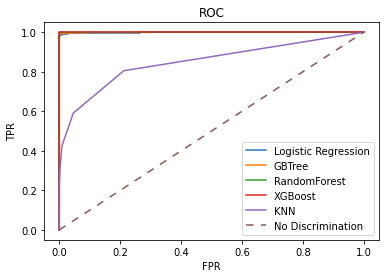

In [53]:
for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
#plt.savefig(os.path.join('plots/roc_curve_all_models.png'))
plt.legend()
plt.show()

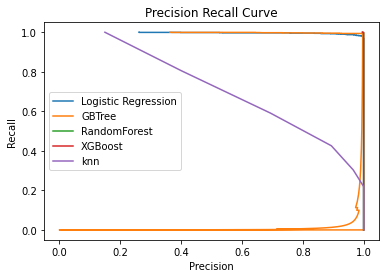

In [54]:
for key in prc_dict:
    clf = prc_dict[key]
    plt.plot(clf['precision'], clf['recall'], label=key)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
#plt.savefig(os.path.join('plots/prc_curve_all_models.png'))

plt.legend()

plt.show()

In [55]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[7409,    0],
       [   9, 1297]])

In [56]:
fpr, tpr, thresholds = roc_curve(y_test,gbtree.predict_proba(X_test)[:,1],pos_label=1)

In [57]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       gbtree.predict_proba(X_test)[:,1],
                                                       pos_label=1)

In [58]:
gb_auc = roc_auc_score(y_test, gbtree.predict_proba(X_test)[:,1])
print("gb_auc: {}".format(gb_auc))

gb_auc: 0.9989886477623238


In [62]:
X_test

array([[ 0.59227257,  0.66020648, -0.56773277, ..., -0.55861065,
         0.75386841, -0.96445582],
       [ 0.42216399,  0.47514004, -0.56773277, ...,  0.24869195,
         0.71697233, -1.07751351],
       [-0.64455859, -0.52176081,  1.76139207, ..., -0.86143413,
        -3.03093544,  0.6522692 ],
       ...,
       [-0.14486463, -0.01766816,  1.76139207, ..., -0.73507377,
        -1.22442181,  1.37554091],
       [-0.61620716, -0.56003466, -0.56773277, ..., -0.84490912,
        -1.93678821, -0.27268406],
       [ 0.13864968,  0.26393652, -0.56773277, ..., -0.26058503,
         0.69288555,  2.01138418]])

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

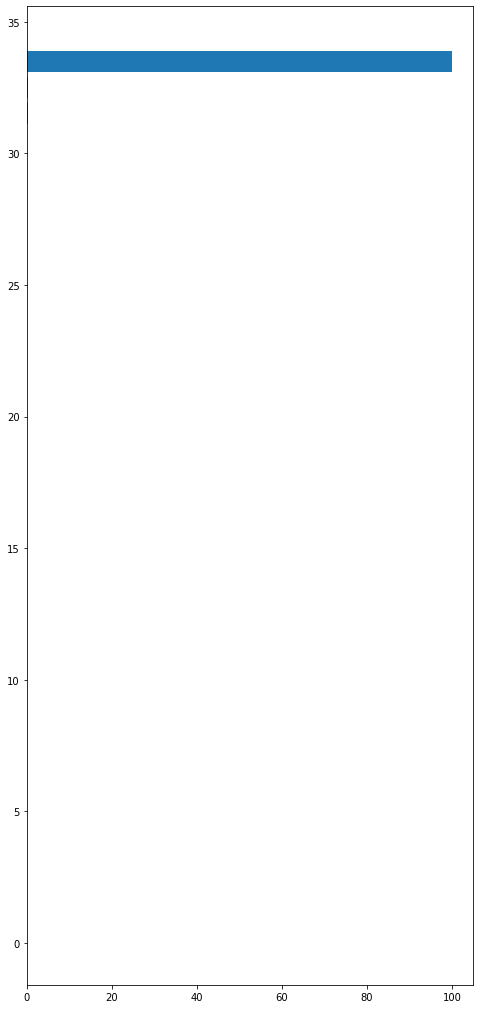

In [59]:
feature_importance = gbtree.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [63]:
#define the param grid
# Parameters of pipelines can be set using ‘__’ separated para
from imblearn.pipeline import Pipeline

clf_grid = {
    "gbtree__max_depth":[3,5,8],
    'gbtree__learning_rate': [0.01,0.05,0.1],
    'gbtree__n_estimators' : [100,500,1000],
    }

#define the pipeline
model_pipe = Pipeline([('gbtree', GradientBoostingClassifier())])

#define the classifer
clf = GridSearchCV(model_pipe,
                   clf_grid,
                   n_jobs=-1,
                   cv=4, 
                   verbose=50, 
                   scoring='roc_auc')


#fit to training data
clf.fit(X_train, y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('gbtree',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gbtree__learning_rate': [0.01, 0.05, 0.1],
                         'gbtree__max_depth': [3, 5, 8],
                         'gbtree__n_estimators': [100, 500, 1000]},
             scoring='roc_auc', verbose=50)

In [64]:
print("Best model parameters: \n")
print(clf.best_params_ )
print("Best model score: \n")
print(clf.best_score_)

Best model parameters: 

{'gbtree__learning_rate': 0.01, 'gbtree__max_depth': 3, 'gbtree__n_estimators': 1000}
Best model score: 

0.999661763251597
